### Sommaire



---


- <a href="#C0"> 0. Importation des données</a>

**Partie 1 :**
- <a href="#C1"> 1. Étude de la faisabilité de la classification textuelle</a>
  - <a href="#C11"> 1.1 Pré-traitement des données textuelles <a>
  - <a href="#C12"> 1.2 Vectorisation des mots/documents <a>
  - <a href="#C13"> 1.3 BERT <a>
  - <a href="#C14"> 1.4 USE - Universal Sentence Encoder <a>

**Partie 2 :**
- <a href="#C2"> 2. Étude de la faisabilité de la classification visuelle </a>
  - <a href="#C21"> 2.1 Importation des images et tests <a>
  - <a href="#C22"> 2.2 Analyse via SIFT <a>
  - <a href="#C23"> 2.3 Analyse via le modèle VGG, par transfer learning <a>

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import re
import seaborn as sns
import missingno as msno
import clean #mon module de fontions qui me permettent de nettoyer un dataframe
import plot_

# Filter warnings
import warnings
warnings.filterwarnings('ignore')

#---------- NLTK
! pip install --user -U nltk
! pip install word2vec
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('wordnet')
nltk.download('words')
from nltk.tokenize import word_tokenize

#-------- Clustering
from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

#------------------ Deep learning

import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


# <a name="C0"> 0. Importation du jeu de données texte <a>

In [ ]:
df = pd.read_csv('/content/flipkart_com-ecommerce_sample_1050.csv')

In [ ]:
#df.info()

In [ ]:
#df.head()

uniq_id                    0.000000
crawl_timestamp            0.000000
product_url                0.000000
product_name               0.000000
product_category_tree      0.000000
pid                        0.000000
retail_price               0.000952
discounted_price           0.000952
image                      0.000000
is_FK_Advantage_product    0.000000
description                0.000000
product_rating             0.000000
overall_rating             0.000000
brand                      0.321905
product_specifications     0.000952
dtype: float64

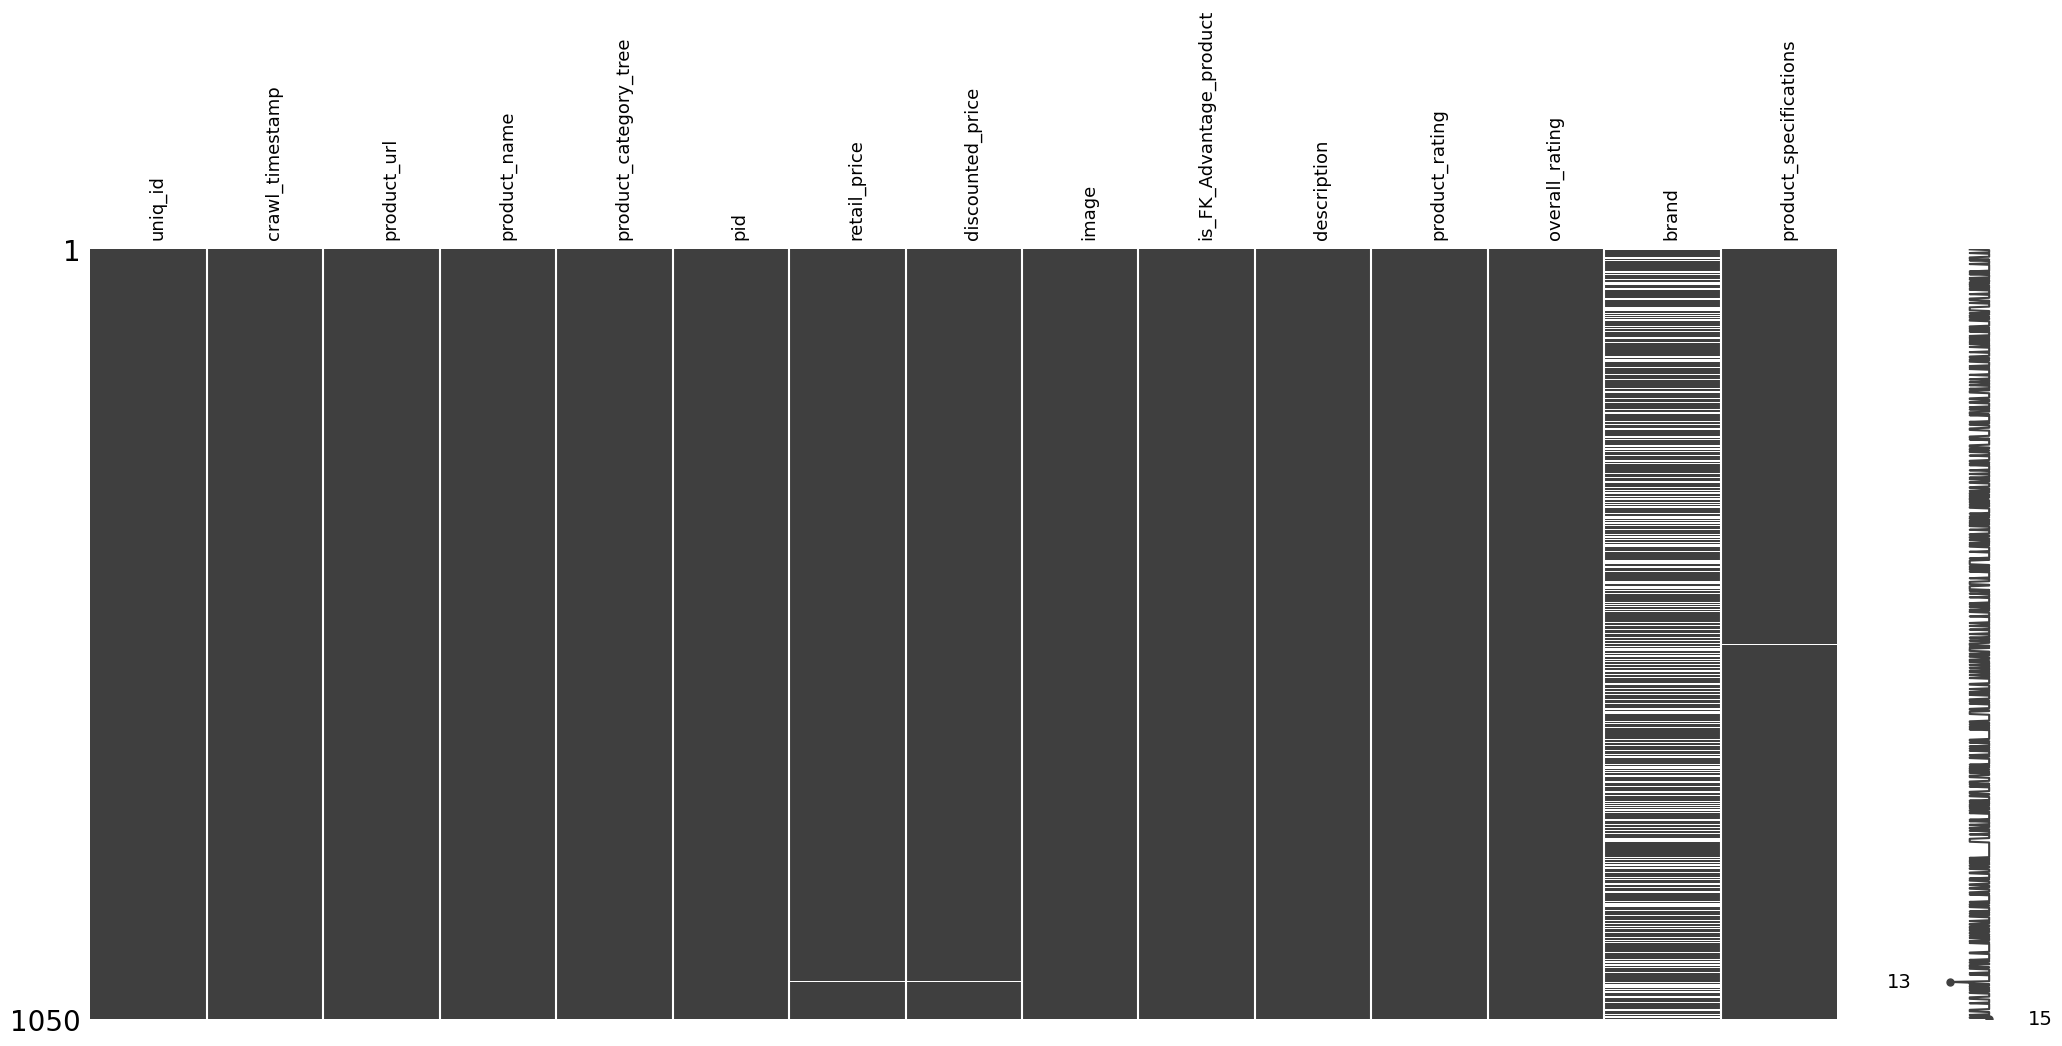

In [ ]:
clean.vm(df, 1., '/content/Fichier_N1/P6_N1_vm.png')

In [ ]:
df[df['product_name'].str.len() == df['product_name'].str.len().min()]

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
335,353ddb2c8ab6920d8ad1055abee87dda,2015-12-01 06:13:00 +0000,http://www.flipkart.com/tenda-a5/p/itmdp2cxeq6...,Tenda A5,"[""Computers >> Network Components >> Routers >...",RTRDNY65WHG9FHTS,1999.0,1999.0,353ddb2c8ab6920d8ad1055abee87dda.jpg,False,Buy Tenda A5 only for Rs. 2250 from Flipkart.c...,5,5,Tenda,"{""product_specification""=>[{""key""=>""In The Box..."
355,26989e846c2096a5b59b59cbea2cc7ab,2015-12-01 06:13:00 +0000,http://www.flipkart.com/tenda-a6/p/itmdngvv3dz...,Tenda A6,"[""Computers >> Network Components >> Routers >...",RTRDNGVME4HGYAM8,1800.0,1399.0,26989e846c2096a5b59b59cbea2cc7ab.jpg,False,Buy Tenda A6 only for Rs. 1800 from Flipkart.c...,4.8,4.8,Tenda,"{""product_specification""=>[{""key""=>""In The Box..."


In [ ]:
clean.info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [ ]:
df[df['retail_price'] == df['retail_price'].max()]

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
11,08452abdadb3db1e686b94a9c52fc7b6,2015-12-04 07:25:36 +0000,http://www.flipkart.com/cartier-w6701005-analo...,"Cartier W6701005 Analog Watch - For Boys, Men","[""Watches >> Wrist Watches >> Cartier Wrist Wa...",WATEAK8SE2RUK7GM,201000.0,201000.0,08452abdadb3db1e686b94a9c52fc7b6.jpg,False,"Cartier W6701005 Analog Watch - For Boys, Men...",No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Chronograp..."


In [ ]:
clean.doublon(df, 'uniq_id')

Recherche de doublon : il y a  0 
doublons qui ont la même clé: uniq_id


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
678,22ac36ba254a68d7dd6173f099771147,2015-12-31 09:19:31 +0000,http://www.flipkart.com/neyth-cotton-set-towel...,Neyth Cotton Set of Towels,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEDRTHRY83HXYY,300.0,170.0,22ac36ba254a68d7dd6173f099771147.jpg,False,Buy Neyth Cotton Set of Towels at Rs. 170 at F...,No rating available,No rating available,Neyth,"{""product_specification""=>[{""key""=>""Material"",..."
679,6c441a6ca8eb4e5ca882c9c0df03ff0c,2015-12-31 09:19:31 +0000,http://www.flipkart.com/asiacraft-goddess-weal...,AsiaCraft Goddess of Wealth Laxmi Brass Statue...,"[""Home Decor & Festive Needs >> Table Decor & ...",SHIE4SFGZYMZ6QUB,385.0,350.0,6c441a6ca8eb4e5ca882c9c0df03ff0c.jpg,False,Buy AsiaCraft Goddess of Wealth Laxmi Brass St...,No rating available,No rating available,AsiaCraft,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
680,025a85a3d1cddc6307f7dc075d8d2132,2015-12-31 09:19:31 +0000,http://www.flipkart.com/soy-impulse-led-bulb/p...,Soy Impulse LED Bulb,"[""Kitchen & Dining >> Lighting >> Bulbs >> Soy...",BLBE2GTCQEHHRMC9,699.0,299.0,025a85a3d1cddc6307f7dc075d8d2132.jpg,False,Buy Soy Impulse LED Bulb for Rs.299 online. So...,No rating available,No rating available,Soy Impulse,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
689,55195de3873fffaa9e37b041533d7305,2015-12-31 09:19:31 +0000,http://www.flipkart.com/philips-9-5-w-led-b22-...,Philips 9.5 W LED B22 3000K A55 IND Bulb,"[""Kitchen & Dining >> Lighting >> Bulbs >> Phi...",BLBEF3HEKYURWHKG,699.0,419.0,55195de3873fffaa9e37b041533d7305.jpg,False,Buy Philips 9.5 W LED B22 3000K A55 IND Bulb f...,No rating available,No rating available,Philips,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,417ae3e8b08acc19a023b8a958644799,2015-12-01 06:13:00 +0000,http://www.flipkart.com/kamasutra-combo-offer-...,Kamasutra Combo Offer Pack Combo Set,"[""Beauty and Personal Care >> Fragrances >> De...",CAGDYY25E8RVC7EG,380.0,358.0,417ae3e8b08acc19a023b8a958644799.jpg,False,Flipkart.com: Buy Kamasutra Combo Offer Pack C...,3.6,3.6,NaN,"{""product_specification""=>[{""key""=>""Number of ..."
337,7680c6bf930669dc0646e3315187dc8c,2015-12-01 06:13:00 +0000,http://www.flipkart.com/arabian-nights-evolve-...,Arabian Nights Evolve Combo Set,"[""Beauty and Personal Care >> Fragrances >> De...",CAGE4B8YHZK3KTUX,799.0,398.0,7680c6bf930669dc0646e3315187dc8c.jpg,False,Flipkart.com: Buy Arabian Nights Evolve Combo ...,4.5,4.5,NaN,"{""product_specification""=>[{""key""=>""Number of ..."
655,f79c9db3abd7faca714c92aeba9b6728,2015-12-31 09:19:31 +0000,http://www.flipkart.com/wood-beauty-photo-fram...,Wood Beauty Wood Photo Frame,"[""Baby Care >> Baby & Kids Gifts >> Photo Fram...",PHFEEDJREU4HHEJG,650.0,450.0,f79c9db3abd7faca714c92aeba9b6728.jpg,False,Buy Wood Beauty Wood Photo Frame for Rs.450 on...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Frame Mate..."
524,797d10fe966b3aa35933669c3425525b,2016-01-07 05:50:25 +0000,http://www.flipkart.com/noise-nosww001-analog-...,"Noise NOSWW001 Analog Watch - For Men, Women","[""Watches >> Wrist Watches >> Noise Wrist Watc...",WATDFFH3KJYBTYGG,999.0,999.0,797d10fe966b3aa35933669c3425525b.jpg,True,"Noise NOSWW001 Analog Watch - For Men, Women ...",4,4,NaN,"{""product_specif

# <a name="C1"> 1. Étude de faisabilité de classification textuelle <a>

## <a name="C11">1.1 Pré-traitement des données textuelles <a>

- ### Choix du corpus

Mon corpus est la colonne product_name ou description , ou le deux ?

In [ ]:
df.loc[89,'product_name']

'Parv Collections Showpiece  -  12 cm'

In [ ]:
#df.loc[0,'description']

In [ ]:
df['product_name'] = df['product_name'].str.lower()
pattern = r'\d+'
repl = ''
df['product_name'] = df['product_name'].str.replace(pattern, repl)

- ### Tokenisation

**Stratégie**



---



*   Supprimer les adjectifs, les verbe, les cc,
*   Visualiser à nouveau les plus courant, les ajouter aux stopwords
*   Supprimer les stopwords



In [ ]:
test = df['product_name'].loc[0]
tok = nltk.pos_tag(word_tokenize('eurospa cotton terry face towel set'))
tok

[('eurospa', 'JJ'),
 ('cotton', 'NN'),
 ('terry', 'NN'),
 ('face', 'NN'),
 ('towel', 'NN'),
 ('set', 'NN')]

Après plusieurs itération j'ai réalisé que le screening des tokens en supprimant les adjectif, et en gardant les nom etc semble pénalisé les modèles. La tokenisation aiutomatique accompagné des stopwords identifié
donne les meilleurs résultats.



---

Ancien code :





```
for i,it in df['product_name'].items():
  tok = nltk.pos_tag(tokenizer.tokenize(it))
  print(tok)
  ls_tok = []
  for token in tok:
    a,b = token
    if b in ['NN', 'NNS']:
      ls_tok.append(a)
    if a in ['showpiece', 'cushions', 'nappy']: #ajout d'une série d'exception pas toujours considéré comme des noms
       ls_tok.append(a)
    df['product_name_token'].loc[i] = ls_tok
```



In [ ]:
df['product_name_token'] = df['product_name']
tokenizer = nltk.RegexpTokenizer(r'\w+')

for i,it in df['product_name'].items():
  df['product_name_token'].loc[i] = tokenizer.tokenize(it)

In [ ]:
#df['product_name_token']
df['product_name_token'].loc[89]

['parv', 'collections', 'showpiece', 'cm']

Essais


```
df['product_name_token'] = df['product_name']

#Tokenizing product_name feature
#df['product_name'] = df['product_name'].str.split()

tokenizer = nltk.RegexpTokenizer(r'\w+')

for i, it in df['product_name'].items():
  df['product_name_token'].loc[i] = tokenizer.tokenize(it)

df['product_name_token']
```



- ### Normalisation et stopwords

In [ ]:
df['category'] = df['product_category_tree']
for i, it in df['category'].items():
  ls = []
  ls = tokenizer.tokenize(it)
  df['category'].loc[i] = ls[0]

In [ ]:
df.loc[122]

uniq_id                                     a63eecfbb02004863fa1f29a0b8105fc
crawl_timestamp                                    2016-06-24 16:03:26 +0000
product_url                http://www.flipkart.com/shopizone-bmw-wheel-32...
product_name                              shopizone bmw wheel  gb  pen drive
product_category_tree      ["Computers >> Storage >> Pen Drives >> Shopiz...
pid                                                         ACCEJWJKZAGJFWCB
retail_price                                                          1999.0
discounted_price                                                       999.0
image                                   a63eecfbb02004863fa1f29a0b8105fc.jpg
is_FK_Advantage_product                                                False
description                Key Features of Shopizone BMW Wheel 32 GB  Pen...
product_rating                                           No rating available
overall_rating                                           No rating available

- ### Lemmatisation

In [ ]:
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
print(wnl.lemmatize('sticker'))

sticker


In [ ]:
from nltk.corpus import words
#test
"sticker" in words.words()

True

In [ ]:
for i, it in df['product_name_token'].items():
  ls_it = []
  for j,token in enumerate(it):
    token_lem = wnl.lemmatize(token)
    if token_lem in words.words():
      ls_it.append(token_lem)
    elif token in ['bedsheet']:
      ls_it.append(token_lem)
    df['product_name_token'].loc[i] = ls_it

#Réfléchir aux exception type bedsheet

In [ ]:
vocab = []
for i, it in df['product_name_token'].items():
  for token in it:
    if not(token in vocab):
      vocab.append(token)

len(vocab)

1148

In [ ]:
df['product_name_token'].loc[89]

['collection', 'showpiece']

Il y a 1 458 mots au total en ne gardant que les 'noms'. Je cherche à repérer les mots courants propre au corpus. Comme le terme 'set'.

In [ ]:
keys = vocab
values = np.zeros(len(vocab))
dictionary = dict(zip(keys, values))
#dictionary

for i, it in df['product_name_token'].items():
  for token in it:
    dictionary[token] += 1

#dictionary

In [ ]:
freq = pd.DataFrame.from_dict(dictionary, orient='index')
freq = freq.reset_index()
freq = freq.rename(columns = {0 : 'fréquence',
                              'index' : 'mot'})
#freq

freq = freq.sort_values('fréquence', ascending = False)
#freq.head(30)

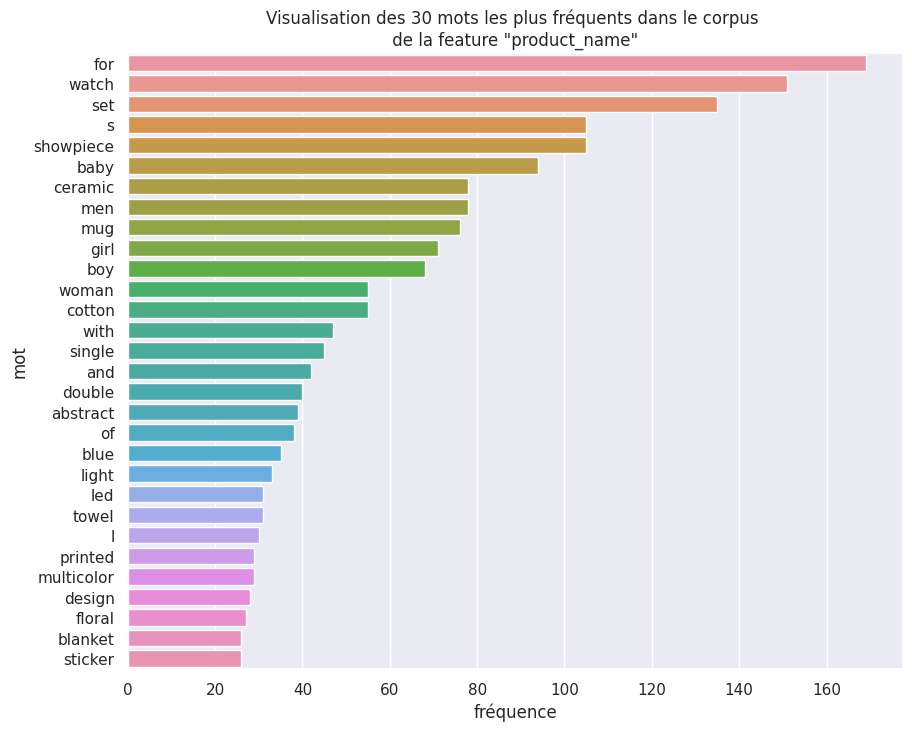

In [ ]:
sns.set()
fig, ax = plt.subplots(figsize = (10,8))
order_ = freq.head(30).index
sns.barplot(data = freq.head(30), y = 'mot', x = 'fréquence', ax = ax)
plt.title('Visualisation des 30 mots les plus fréquents dans le corpus \n de la feature "product_name" ')
plt.savefig('/content/Fichier_N1/P6_N1_graphe1.png', bbox_inches = 'tight')

Les catégories dominantes :

* des bibelots
* des montres
* des mugs

Les stop_words propre au corpus à mon sens :


```
'set', 'analog', 'cm', 'combo', 's', 'cotton'
```




In [ ]:
postag_ = nltk.pos_tag(freq.mot[:10].tolist())
postag_

[('for', 'IN'),
 ('watch', 'NN'),
 ('set', 'VBN'),
 ('s', 'JJ'),
 ('showpiece', 'NN'),
 ('baby', 'NN'),
 ('ceramic', 'JJ'),
 ('men', 'NNS'),
 ('mug', 'VBP'),
 ('girl', 'NN')]

Chercher tous les noms communs d'objets dans la liste de stopwords ls_stopwords

In [ ]:
ls_stopwords = ['set',  's', 'cotton', 'l', 'men', 'woman', 'girl', 'boy', 'abstract', 'multicolor',
                'maximum', 'sonata']

In [ ]:
df['brand'] = df['brand'].str.lower()
ls_brand = df['brand'].unique().tolist()
ls_brand.remove(np.nan)

In [ ]:
ls_brand

['elegance',
 'sathiyas',
 'eurospa',
 'santosh royal fashion',
 'jaipur print',
 'house this',
 'riva carpets',
 'myesquire',
 'dungri india craft',
 'bft',
 'jmd',
 'mom and kid',
 "kripa's",
 'burt s bees',
 'akup',
 'd-link',
 'suave',
 'roq',
 'cookart',
 'jrb',
 'rythmx',
 'brillare science',
 'mars',
 'aroma care',
 'kohl',
 'shopmania',
 'chhote janab',
 'prime',
 'ski',
 'gayatri creations',
 'caffeine',
 'garnet',
 'vitamins',
 'ke',
 'giorgio armani',
 'florence9',
 'vareesha',
 'treasure',
 'chinmay kids',
 'heavenly',
 '@home',
 'smart wall guru',
 'oxford',
 'eureka.in',
 'craft trade',
 'parv collections',
 'exotic india',
 'aapno rajasthan',
 'beyoutiful',
 'my angel',
 'diviniti',
 'k&p',
 'rama',
 'shop rajasthan',
 'bestway',
 'artisan creation',
 'remtex export',
 'twisha',
 'eternity',
 'fs mini klub',
 'omic',
 'filink',
 'recrafto',
 'frenemy',
 'quilt india',
 'toffyhouse',
 'shopizone',
 'craftcart',
 'sos',
 'arsalan',
 'famous',
 'rastogi handicrafts',
 'nehp

In [ ]:
tokenizer = nltk.RegexpTokenizer(r'\w+')
ls_brand_tok = set()
for brand in ls_brand:
  #print(brand)
  ls = tokenizer.tokenize(brand)
  ls_brand_tok.update(ls)

for words_brand in list(ls_brand_tok) :
  if words_brand in words.words():
    ls_brand_tok.remove(words_brand)

In [ ]:
sw = set()
sw.update(ls_stopwords)
sw.update(ls_brand_tok)
sw.update(tuple(nltk.corpus.stopwords.words('english')))
#sw

In [ ]:
for i, it in df['product_name_token'].items():
  df['product_name_token'].loc[i] = [w for w in it if not w in list(sw)]

In [ ]:
df['product_name_token'].sort_values()
ind = []
for i, it in df['product_name_token'].sort_values().items():
  if len(it)==0:
    ind.append(i)
#Repérer les index avec liste vide

print('liste vide', round((len(ind)/len(df))*100), '% du dataset')

liste vide 3 % du dataset


In [ ]:
df.loc[ind, 'product_name'].tolist()

['jaipan kd. kadhai . l',
 'digisol dg-bgn',
 'frenemy mpad mousepad',
 'asus dsl-n_c',
 'archies vj- combo set',
 'iball wra',
 'tenda gm',
 'tenda fh',
 'spinz combo set',
 'tenda a',
 'edimax br-acl',
 'zyxel pla-',
 'tenda a',
 'binatone wrn',
 'antiqueshop abkl_grn_grn_grn',
 'antiqueshop abkl_pl_pnk_pnk',
 'edimax br-nc',
 'antiqueshop abkl_pl_pl_pnk',
 'archies vj- combo set',
 'archies vj- combo set',
 'suruchi kadhai . l',
 'kalash kadhai . l',
 'intex wd',
 'kalash kadhai . l',
 'nirlon kadhai  l',
 'ndura kadhai . l',
 'yardley  combo set',
 'tenda gr+',
 'netis wf-']

Je supprime les produits pour lesquels j'obtiens une liste de tokens vide.

Il représente 3% du dataset. Leur description n'est pas très expressives et serait difficle à classer.





In [ ]:
df = df.drop(ind)
df = df.reset_index(drop =True)

In [ ]:
df['product_name_token'].loc[89]

['collection', 'showpiece']

In [ ]:
df['product_name'].loc[89]

'parv collections showpiece  -   cm'

In [ ]:
#Suppression des doublons pour chaque document
for i, it in df['product_name_token'].items():
  set_ = set(it)
  ls_new = list(set_)
  df['product_name_token'].loc[i] = ls_new

## <a name="C12"> 1.2 Feature engineering - type 1 <a>

Premier type de feature engineering :


*   bag of words - we  == 1
*   Tf-Idf - we  == 2
*   word2vec (prend le contexte de chaque mots en compte) - we  == 3



- ### Type 1

In [ ]:
we = 3 # 1, 2 , 3
from gensim.models import Word2Vec as w2v
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim


sw = list(sw)

#Utilisation de la fonction scikit learn sans nouvelle tokenisation, juste pour obtenir le bag of word
def identity_tokenizer(text):
    return text

corpus = df['product_name'].tolist()
#corpus = df['product_name_token'].tolist()

if we == 1:
  vectorizer = CountVectorizer(
                             #tokenizer = identity_tokenizer,
                             token_pattern = r'\w+',
                             lowercase = False,
                             stop_words= sw,
                             max_df=0.95,
                             min_df=1
                             )
  X = vectorizer.fit_transform(corpus)
  vocab = vectorizer.get_feature_names_out()
  print(X.shape)
elif we == 2:
  vectorizer = TfidfVectorizer(
                             #tokenizer = identity_tokenizer,
                             token_pattern = r'\w+',
                             lowercase = False,
                             stop_words= sw,
                             max_df=0.95,
                             min_df=1
                             )
  X = vectorizer.fit_transform(corpus)
  vocab = vectorizer.get_feature_names_out()
  print(X.shape)
elif we == 3:
  corpus = df['product_name_token'].tolist()
  vector_size = 300
  w = w2v(corpus,
          min_count = 1,
          vector_size = vector_size, #300
          window = 8,
          sg = 1)
  w.build_vocab(corpus)
  w.train(corpus, total_examples=w.corpus_count, epochs = 900)
  model_vectors = w.wv
  w2v_words = model_vectors.index_to_key
  print("Vocabulary size: %i" % len(w2v_words))
  print("Word2Vec trained")



Vocabulary size: 1093
Word2Vec trained


- ### Création de la matrice d'embedding

In [ ]:
# Préparation des sentences (tokenization)
if we == 3:
  print("Fit Tokenizer ...")
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus) #création de la séquence d'entier, les index des mots
  x_sentences = pad_sequences(tokenizer.texts_to_sequences(corpus), #équivalent transform
                                                     maxlen=len(w2v_words),
                                                     padding='post') #Créé une matrice 2D, n_samples x n_len_vocab, une ligne correspond à un texte
                                                     # la ligne est rempli de zero et des indices correspondant au mot du vocabulaire
                                                     # Avec post, les première colonnes sont d'abord rempli

  num_words = len(tokenizer.word_index) + 1
  print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 1094


In [ ]:
if we !=3:
  bagofw = pd.DataFrame(X.todense(), columns=vocab, index = df.product_name)
  bagofw
else :
  # Création de la matrice d'embedding
  print("Create Embedding matrix ...")
  w2v_size = vector_size
  word_index = tokenizer.word_index # word_index, dictionnaire de chaque mot du vocabulaire, word : index
  vocab_size = len(word_index) + 1
  embedding_matrix = np.zeros((vocab_size, w2v_size)) #initialisation de la matrice par des coefficients zero chaque ligne est le vecteur correspond à un mot du vocabulaire
  i=0
  j=0
  for word, idx in word_index.items(): #itération sur les mots de l'index
      i +=1
      if word in w2v_words: #si le mot répertorié dans l'index l'est également dans le vocabulaire
          j +=1
          embedding_vector = model_vectors[word] #on récupère le vecteur du mot
          if embedding_vector is not None: #s'il n'est pas vide
             embedding_matrix[idx] = model_vectors[word] #On a ajoure ce vecteur à la i-ème ligne de la matrice

  word_rate = np.round(j/i,4)
  print("Word embedding rate : ", word_rate) #Le taux de mot qui se trouve à la fois dans le dictionnaire et dans le vocabulaire
  print("Embedding matrix: %s" % str(embedding_matrix.shape))


Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (1094, 300)


In [ ]:
l_cat = list(set(df['category']))
l_cat

['Beauty', 'Home', 'Baby', 'Watches', 'Kitchen', 'Computers']

- ### Modèle de sentence embedding (WORD2vec)

In [ ]:
#Création d'un modèle de document embedding using a perceptron avec une couche d'embedding et une couche de 'averaging)
if we == 3:
# Création du modèle
  maxlen=len(w2v_words)
  word_input=Input(shape=(maxlen,),dtype='float64') #Création d'un tenseur de type input, vecteur de taille n_word sans préciser le nombre de batch
  word_embedding=Embedding(input_dim=vocab_size, #Création d'une embedding layer qui, pour chaque integer, renvoie un vector correspondant
                         output_dim=w2v_size,
                         weights = [embedding_matrix], #On renseigne la matrice issu de l'entraînement de Word2vec, chaque ligne correspond à un mot et
                         #son vecteur ligne associé
                         input_length=maxlen)(word_input)
  word_vec=GlobalAveragePooling1D()(word_embedding)  #Couche qui renvoie le vecteur moyen pour chaque document
  embed_model = Model([word_input],word_vec) #Création du modèle, en précisant les inputs et output

  embed_model.summary()
  embeddings = embed_model.predict(x_sentences) #Application à la matrice des indices
  embeddings.shape

  #À chaque document, un vecteur est désormais associé

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1093)]            0         
                                                                 
 embedding_1 (Embedding)     (None, 1093, 300)         328200    
                                                                 
 global_average_pooling1d_1   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 328,200
Trainable params: 328,200
Non-trainable params: 0
_________________________________________________________________
32/32 [==============================] - 1s 17ms/step


### Résultats ARI

In [ ]:
import time
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)

    # Détermination des clusters à partir des données après Tsne
    cls = KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(adjusted_rand_score(df['category'], cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)

    return ARI, X_tsne, cls.labels_

In [ ]:
y = df['category'].values

In [ ]:
if we != 3:
  bagofw = bagofw.reset_index()
  ind_ = bagofw.index

In [ ]:
ind_ = df.index
if we != 3:
  X_emb = bagofw.drop(columns = 'product_name').values
else :
  X_emb = embeddings

In [ ]:
# first reduce dimensionality before feeding to t-sne
#Premier choix de réduction de dimension pca

from sklearn.decomposition import PCA
if we !=3:
  vector_size = X.shape[1] #300 pour le word2vec
pca = PCA(n_components=int(0.1*vector_size), random_state = 42)
X_pca = pca.fit_transform(X_emb)
ARI, X_tsne, labels = ARI_fct(X_pca)
df_tsne = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])
df_tsne['category'] = df['category'].values
df_tsne['product'] = np.nan

ARI :  0.3296 time :  18.0


In [ ]:
df_tsne.head()

,Dim1,Dim2,category,product
0,27.779961,-34.335880,Home,NaN
1,17.255213,11.076130,Baby,NaN
2,16.045725,13.440307,Baby,NaN
3,23.902740,-23.635090,Home,NaN
4,24.491201,-23.245338,Home,NaN


In [ ]:
#Vérification
df.loc[740]

uniq_id                                     8aa19c1f26ee1f256d4c3ab5f2f849be
crawl_timestamp                                    2015-12-12 11:46:53 +0000
product_url                http://www.flipkart.com/xemex-st1025sl07-new-g...
product_name               xemex stsl new generation analog watch  - for ...
product_category_tree      ["Watches >> Wrist Watches >> Xemex Wrist Watc...
pid                                                         WATE6KYGHHMDFFMK
retail_price                                                           650.0
discounted_price                                                       275.0
image                                   8aa19c1f26ee1f256d4c3ab5f2f849be.jpg
is_FK_Advantage_product                                                False
description                Xemex ST1025SL07 New Generation Analog Watch  ...
product_rating                                                             5
overall_rating                                                             5

In [ ]:
for i, it in df['product_name_token'].items():
  #print(it)
    if len(it) >1:
      df_tsne['product'].loc[i] = it[-2]+','+it[-1]
    else :
      df_tsne['product'].loc[i] = it[-1]

### Représentation graphique

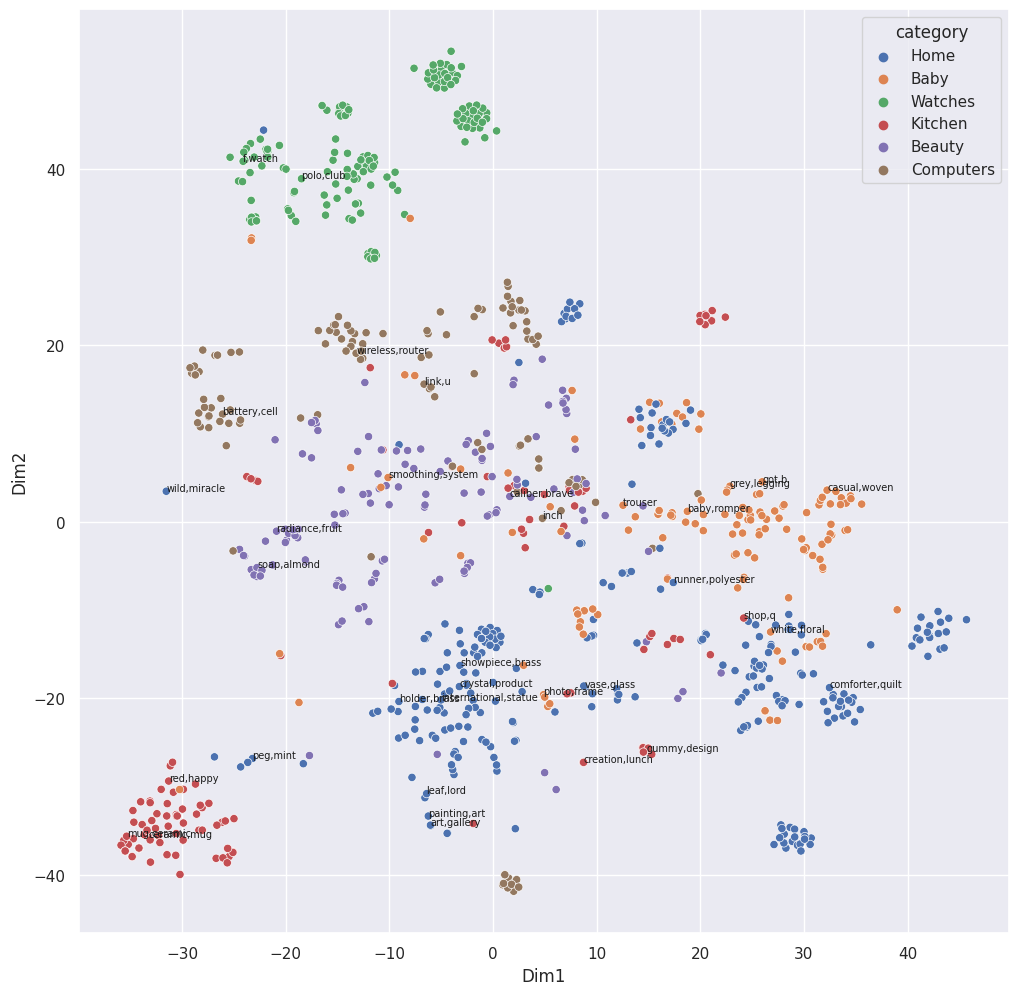

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(data=df_tsne, x='Dim1', y='Dim2',hue = 'category')
  # randomly sample
tmp = df_tsne.sample(35)
  #add label to some random points per group
for _,row in tmp.iterrows():
  plt.annotate(row['product'], (row['Dim1'], row['Dim2']), size=7, color='k')
plt.savefig('/content/Fichier_N1/P6_N1_TSNE_'+str(we)+'.png')
plt.show()


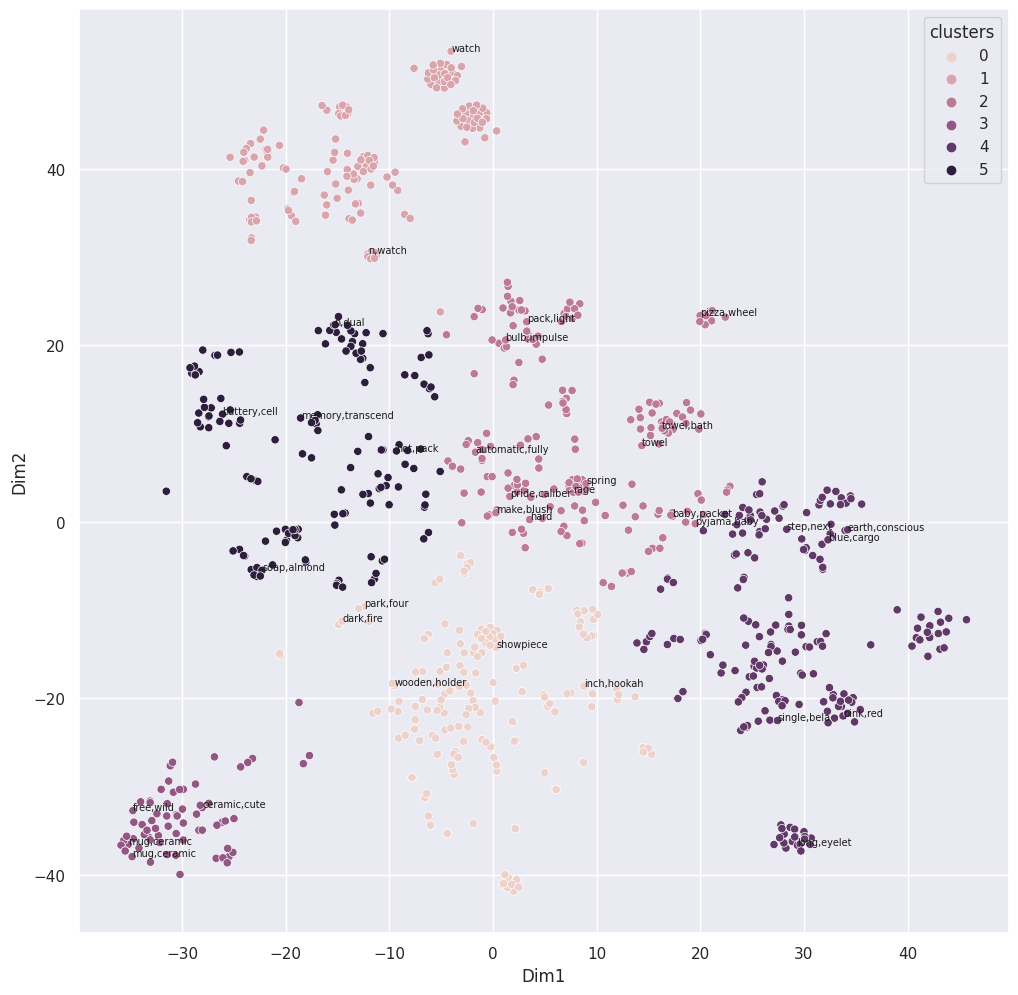

In [ ]:
df_tsne['clusters'] = labels
sns.set()
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(data = df_tsne, x = 'Dim1', y= 'Dim2', hue ='clusters')
tmp = df_tsne.sample(35)
#add label to some random points per group
for _,row in tmp.iterrows():
  plt.annotate(row['product'], (row['Dim1'], row['Dim2']), size=7, color='k')
plt.savefig('/content/Fichier_N1/P6_N1_TSNE_k_means_'+str(we)+'.png')
plt.show()


## <a name="C13">  1.3 Feature engineering - type 2  <a>


Second type de feature engineering avec réseau de neurones :

* BERT
* USE

- ### BERT

In [ ]:
! pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.4 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [ ]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.12.0
2.12.0
Num GPUs Available:  0
True


Stratégie : je crée une nouvelle feature que le tokenize BERT pourra prendre en compte. Et ainsi palier à l'incompatibilité avec le format de la série product_name_token.

In [ ]:
df['test'] = df['product_name_token']

In [ ]:
for idx, sent in df['test'].items():
  new_string = ' '.join(df['test'].loc[idx])
  df['test'].loc[idx] = new_string

#### Fonctions communes

In [ ]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        #encode_plus tranforme une phrase sous forme de token et renvoie un batch encoding, un champs avec :
        #inputs_ids, un vecteur contenant les id de chaque token
        #token_type_ids, pour chaque sentence, un vecteur qui encode les token de contexte en leur associant la valeur 0 et les token de valeur 1
        #attention mask, indique à l'algorithme les indices des valeurs 'padded', les zeros ajoutés pour que
        #les vecteurs correspondant à chaque séquence aient une taille identique
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
        #Création de 4 structure array/ liste
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, token_type_ids, attention_mask, bert_inp_tot


# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size],
                                                                      bert_tokenizer, max_length)

        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids,
                                 "input_mask" : attention_mask,
                                 #"input_type_ids" : token_type_ids
                                 }
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)

    return features_bert, last_hidden_states_tot

In [ ]:
max_length = 64 #max_length = max(df['test'].str.len())
batch_size = 100
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type) #Téléchargement du modèle pré-entraîné, BERT
sentences = df['product_name'].to_list() #sentences = df['test'].to_list()

In [ ]:
len(sentences)

1021

In [ ]:
# Création des features
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='HF')

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.30.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_ac

1/1 [==============================] - 27s 27s/step
temps traitement :  381.0


In [ ]:
last_hidden_states_tot

array([[[-5.29453814e-01, -2.73920149e-01, -3.00437927e-01, ...,
         -1.28313601e-01, -9.01088268e-02,  4.18098420e-01],
        [-3.95981371e-01, -4.60285693e-01, -1.20416582e-02, ...,
         -3.47492844e-01,  5.20850658e-01,  3.69193792e-01],
        [ 4.46172088e-01, -2.25457385e-01,  7.62868285e-01, ...,
          2.98271000e-01, -2.50241190e-01,  5.83565831e-01],
        ...,
        [ 1.00826234e-01, -9.06674713e-02,  2.05460817e-01, ...,
         -1.60580531e-01, -1.14625379e-01, -1.11221969e-02],
        [-5.05617745e-02, -3.09311301e-01,  6.37569189e-01, ...,
          8.84460956e-02, -2.20768809e-01, -3.88136834e-01],
        [ 4.56475988e-02, -4.99466583e-02,  2.36538693e-01, ...,
         -1.29393861e-02, -1.59422264e-01, -1.33673370e-01]],

       [[-4.89566714e-01,  2.16280937e-01, -3.72355640e-01, ...,
         -3.20393115e-01,  2.33932421e-01,  2.18114763e-01],
        [ 6.44536555e-01, -9.96968508e-01, -2.53007233e-01, ...,
          1.71064049e-01,  1.74120873e

In [ ]:
features_bert.shape

(1000, 768)

In [ ]:
features_bert

array([[-6.79669231e-02, -2.63799042e-01,  1.88245073e-01, ...,
        -8.60709921e-02, -8.90468359e-02,  9.86370724e-04],
       [ 1.96584776e-01, -9.96519923e-02, -1.58230541e-04, ...,
        -2.13910088e-01,  3.47732045e-02, -1.69099852e-01],
       [ 1.76970273e-01, -3.24646056e-01,  2.71865241e-02, ...,
        -2.40373816e-02, -1.83911070e-01, -4.38095033e-02],
       ...,
       [ 3.36499438e-02, -2.90050149e-01,  4.11852151e-01, ...,
         6.16085827e-02, -1.16052404e-01, -9.48937833e-02],
       [ 8.82554203e-02, -2.88305759e-01,  3.59388560e-01, ...,
         9.11894441e-02, -1.59329623e-01, -1.28101036e-01],
       [ 2.50088632e-01, -1.93427190e-01,  3.75543475e-01, ...,
        -3.56698364e-01, -4.19471264e-01, -6.72679767e-02]], dtype=float32)

In [ ]:
def ARI_fct_ter(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)

    # Détermination des clusters à partir des données après Tsne
    cls = KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(adjusted_rand_score(df['category'][:1000], cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)

    return ARI, X_tsne, cls.labels_

In [ ]:
vector_size = 768 #if bag of word
pca = PCA(n_components=int(0.1*vector_size), random_state = 42)
X_pca = pca.fit_transform(features_bert)
ARI, X_tsne, labels = ARI_fct_ter(X_pca)
df_tsne = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])
df_tsne['category'] = df['category'][:1000].values
df_tsne['product'] = np.nan

ARI :  0.4634 time :  20.0


In [ ]:
for i, it in df['product_name_token'][:1000].items():
#print(it)
  if len(it) >1:
    df_tsne['product'].loc[i] = it[-2]+','+it[-1]
  else :
    df_tsne['product'].loc[i] = it[-1]

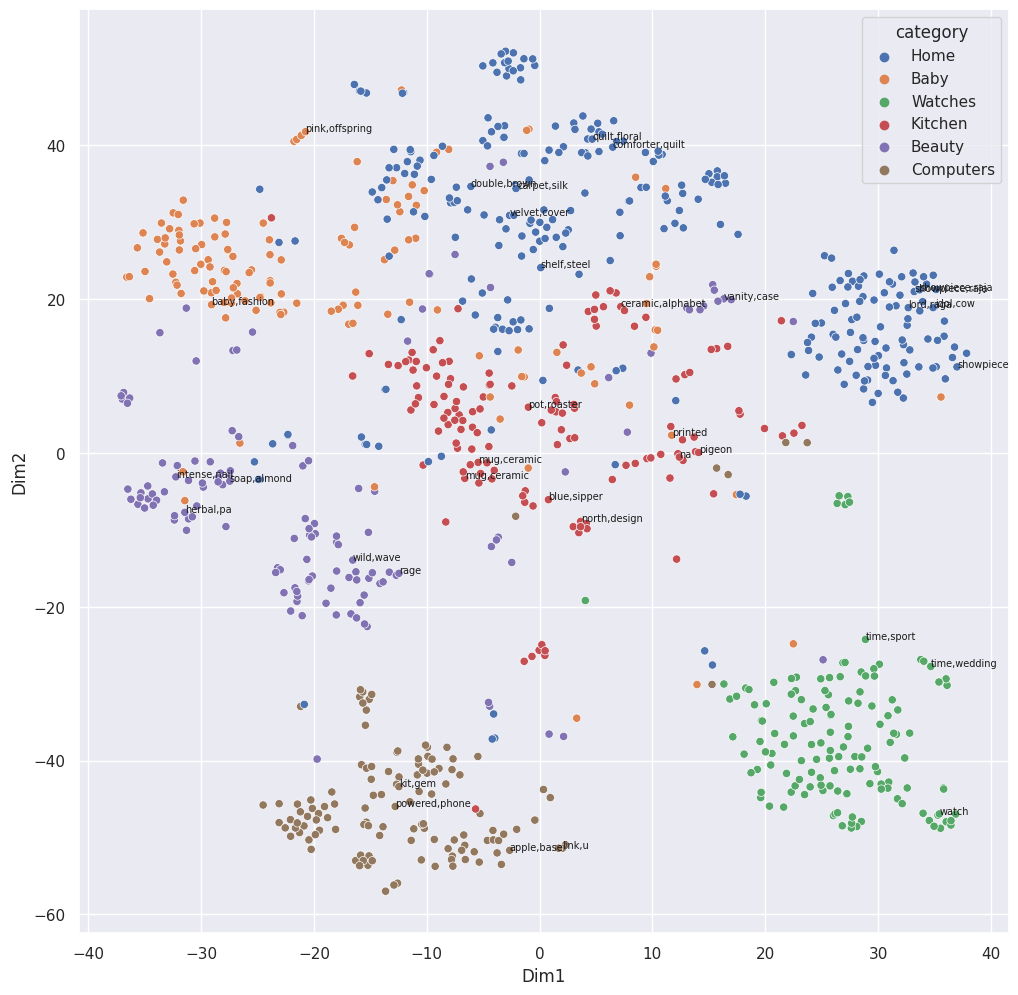

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(data=df_tsne, x='Dim1', y='Dim2',hue = 'category')
  # randomly sample
tmp = df_tsne.sample(35)
  #add label to some random points per group
for _,row in tmp.iterrows():
  plt.annotate(row['product'], (row['Dim1'], row['Dim2']), size=7, color='k')
plt.savefig('/content/Fichier_N1/P6_N1_TSNE_BERT.png')
plt.show()

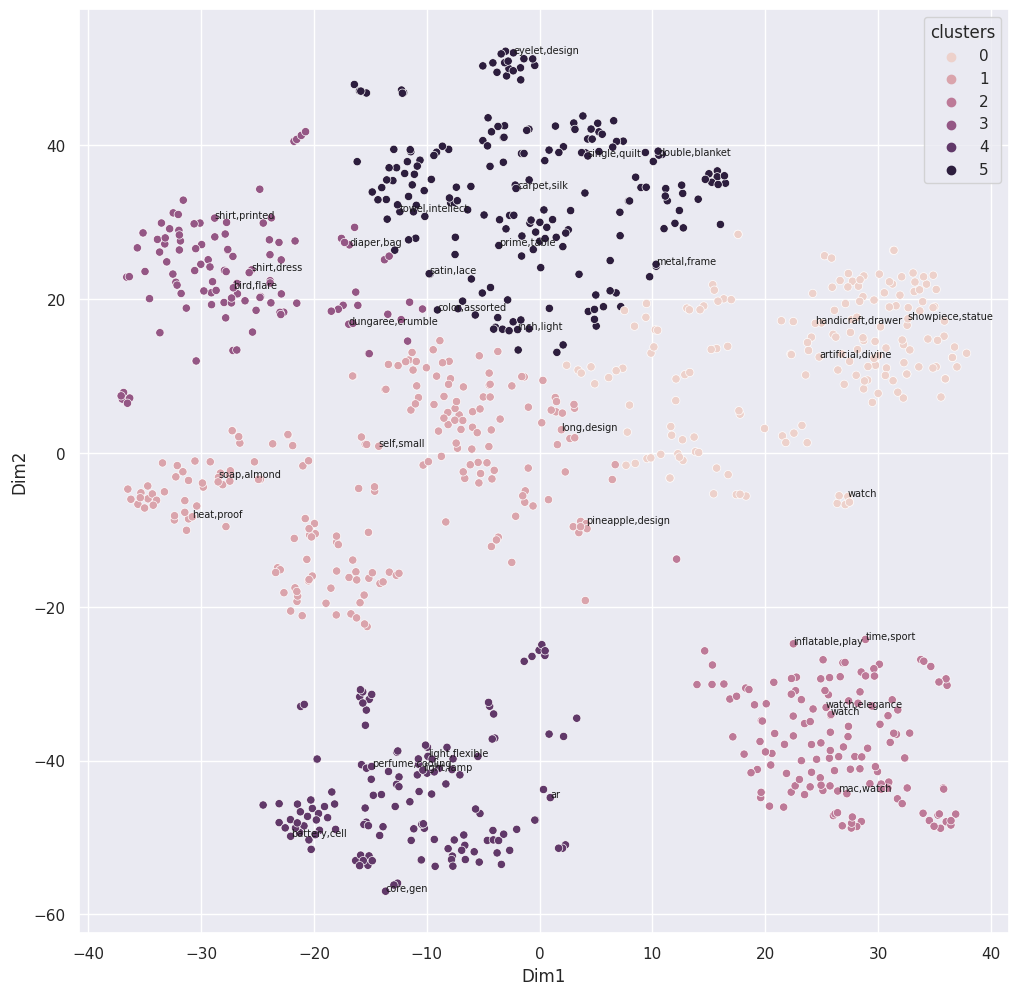

In [ ]:
df_tsne['clusters'] = labels
sns.set()
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(data = df_tsne, x = 'Dim1', y= 'Dim2', hue ='clusters')
tmp = df_tsne.sample(35)
#add label to some random points per group
for _,row in tmp.iterrows():
  plt.annotate(row['product'], (row['Dim1'], row['Dim2']), size=7, color='k')
plt.savefig('/content/Fichier_N1/P6_N1_TSNE_k_means_BERT.png')
plt.show()


- ### USE - Universal Sentence Encoder

In [ ]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [ ]:
batch_size = 100
sentences = df['product_name'].to_list()

In [ ]:
features_USE = feature_USE_fct(sentences, batch_size)

In [ ]:
features_USE.shape

(1000, 512)

In [ ]:
def ARI_fct_ter(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)

    # Détermination des clusters à partir des données après Tsne
    cls = KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(adjusted_rand_score(df['category'][:1000], cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)

    return ARI, X_tsne, cls.labels_

In [ ]:
vector_size = features_USE.shape[1]
pca = PCA(n_components=int(0.1*vector_size), random_state = 42)
X_pca = pca.fit_transform(features_USE)
ARI, X_tsne, labels = ARI_fct_ter(X_pca)
df_tsne = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])
df_tsne['category'] = df['category'][:1000].values
df_tsne['product'] = np.nan

ARI :  0.5204 time :  36.0


In [ ]:
for i, it in df['product_name_token'][:1000].items():
#print(it)
  if len(it) >1:
    df_tsne['product'].loc[i] = it[-2]+','+it[-1]
  else :
    df_tsne['product'].loc[i] = it[-1]

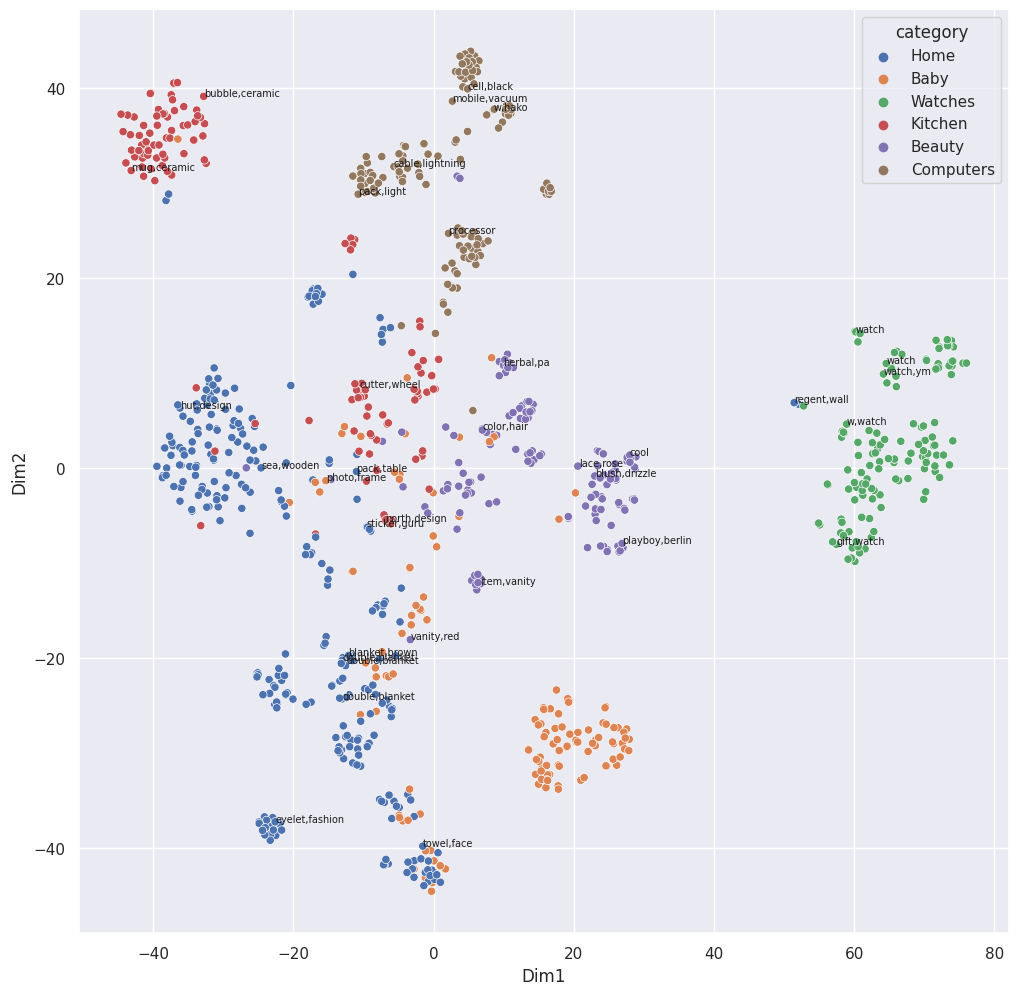

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(data=df_tsne, x='Dim1', y='Dim2',hue = 'category')
  # randomly sample
tmp = df_tsne.sample(35)
  #add label to some random points per group
for _,row in tmp.iterrows():
  plt.annotate(row['product'], (row['Dim1'], row['Dim2']), size=7, color='k')
plt.savefig('/content/Fichier_N1/P6_N1_TSNE_USE.png')
plt.show()

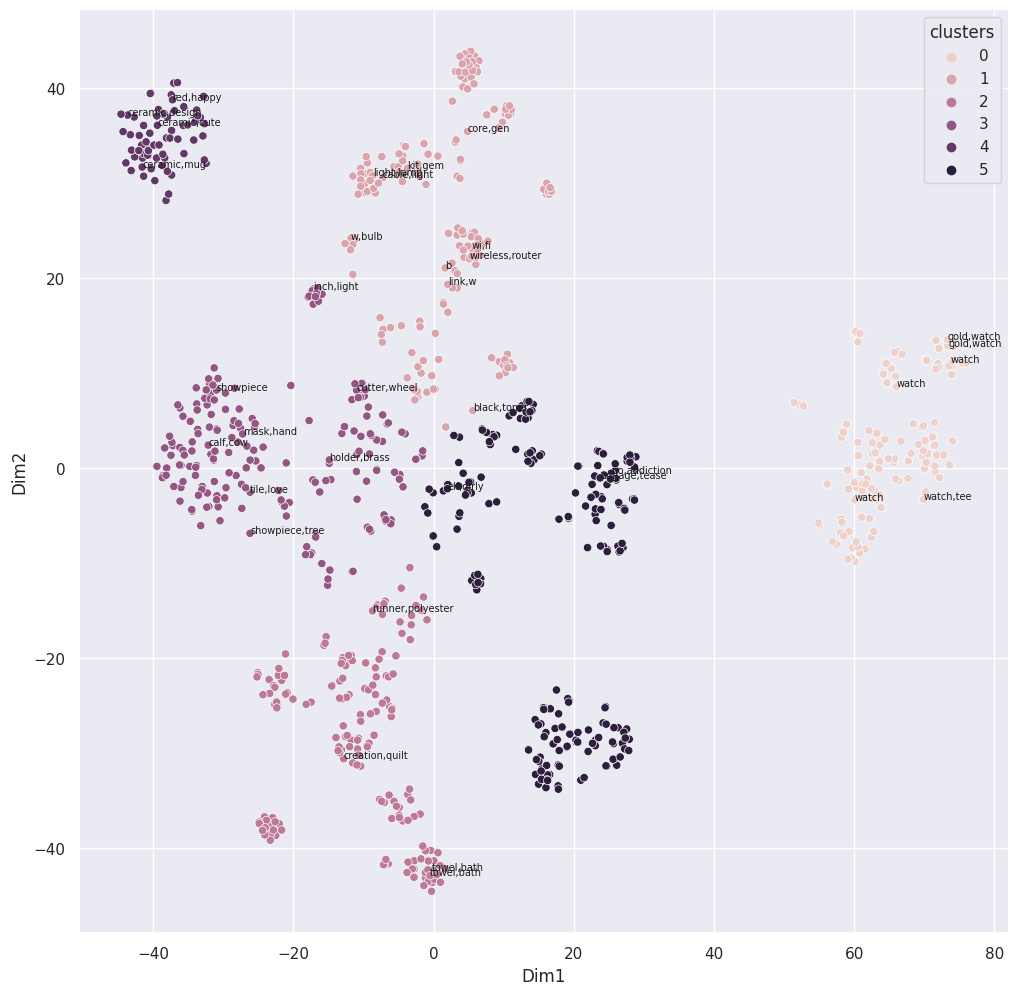

In [ ]:
df_tsne['clusters'] = labels
sns.set()
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(data = df_tsne, x = 'Dim1', y= 'Dim2', hue ='clusters')
tmp = df_tsne.sample(35)
#add label to some random points per group
for _,row in tmp.iterrows():
  plt.annotate(row['product'], (row['Dim1'], row['Dim2']), size=7, color='k')
plt.savefig('/content/Fichier_N1/P6_N1_TSNE_k_means_USE.png')
plt.show()


 # <a name="C2"> 2. Étude de la faisabilité de la classification visuelle </a>

## <a name="C21"> 2.1 Importation des images et tests <a>

In [ ]:
from os import listdir
!unzip /content/Images.zip -d /content/Images

Archive:  /content/Images.zip
replace /content/Images/__MACOSX/._Images? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
path = "/content/Images/Images/"
list_photos = [file for file in listdir(path)]
print(len(list_photos))

1050


In [ ]:
df

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,NB_NAN,product_name_token,category
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,elegance polyester multicolor abstract eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",0,"[elegance, polyester, multicolor, abstract, ey...",Home
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,sathiyas cotton bath towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",0,"[sathiyas, cotton, bath, towel]",Baby
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,eurospa cotton terry face towel set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",2,"[eurospa, cotton, terry, face, towel, set]",Baby
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,santosh royal fashion cotton printed king size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",0,"[santosh, royal, fashion, cotton, printed, kin...",Home
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,jaipur print cotton floral king sized double b...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",0,"[jaipur, print, cotton, floral, king, sized, d...",Home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,oren empower extra large self adhesive sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ...",0,"[oren, empower, extra, large, self, adhesive, ...",Baby
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,wallmantra large vinyl sticker sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,Wallmantra Large Vinyl Sticker Sticker (Pack o...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ...",0,"[wallmantra, large, vinyl, sticker, sticker]",Baby
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,uberlyfe extra large pigmented polyvinyl films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STI

In [ ]:
df.groupby("category")['image'].count()

category
Baby         150
Beauty       150
Computers    150
Home         300
Kitchen      150
Watches      150
Name: image, dtype: int64

Home
/content/Images/Images/57578c1e6ec61a880a6f3f971f5f77b8.jpg
/content/Images/Images/4e130ed339dcfe20d2c8b66892278a94.jpg
/content/Images/Images/374e63028d691c380bc43b0dc60e460d.jpg


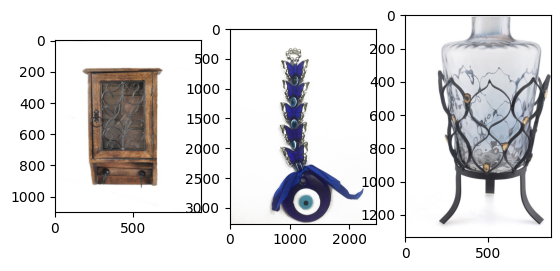

Baby
/content/Images/Images/184ecf07ca4e2872eaf53d2344a1e783.jpg
/content/Images/Images/f1ee63a5f0db853e2c1b377778580d39.jpg
/content/Images/Images/8015db34d09642b046c775e8157dd729.jpg


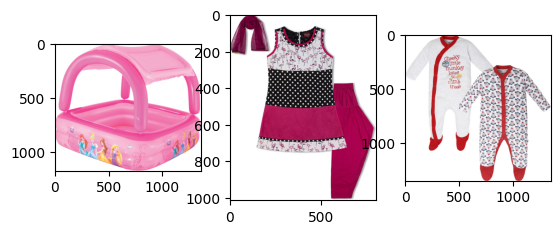

Watches
/content/Images/Images/733aa1e801a139fa8dc7be9f0eff5ee0.jpg
/content/Images/Images/62c35de4df27437d3597963fac55a8b6.jpg
/content/Images/Images/33d97d63c037078cd3f08033966d6a88.jpg


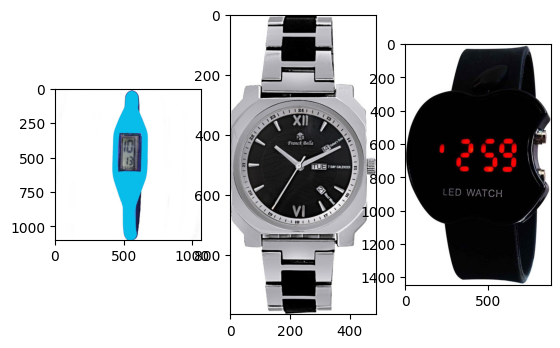

Kitchen
/content/Images/Images/9ba898ecb77ab5a6799c8b047c6b6008.jpg
/content/Images/Images/afc3ebd18df498dd87abb7ad7536b5c7.jpg
/content/Images/Images/0096e89cc25a8b96fb9808716406fe94.jpg


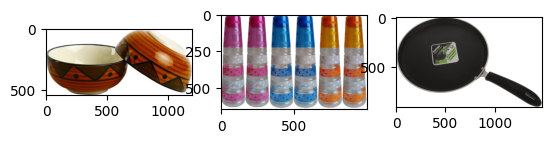

Beauty
/content/Images/Images/059493eeb88ebb4cc08d1522f3f87c3f.jpg
/content/Images/Images/9613f2f1e65fb1fc7e181e7f83c217da.jpg
/content/Images/Images/640fd08bb3ba538d67a5c0c2c61a5c4c.jpg


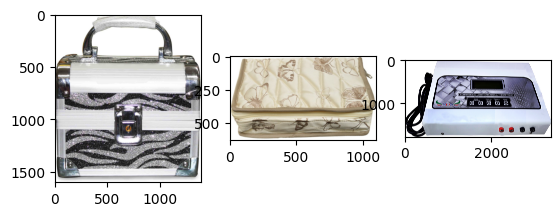

Computers
/content/Images/Images/fd2716d0e5dd7ffc367ca4dd9f97aaa0.jpg
/content/Images/Images/5df72b5295dc5e6126693e640b50f3a2.jpg
/content/Images/Images/f309bdd259c5b46a560bc1620e641947.jpg


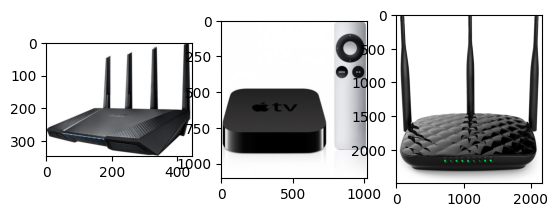

In [ ]:
from matplotlib.image import imread
def list_fct(name) :
    df_tamp = df[df['category'] == name]
    list_image_name = df_tamp['image'].tolist()
    return list_image_name

list_labels = df['category'].unique().tolist()

for name in list_labels :
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + list_fct(name)[i+12]
        print(filename)
        image = imread(filename)
        plt.imshow(image)
    plt.show()

In [ ]:
df[df['uniq_id']== '486e98154514ed485f0b2f9bc9f24549']

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,NB_NAN,product_name_token,category
922,486e98154514ed485f0b2f9bc9f24549,2016-01-01 13:15:34 +0000,http://www.flipkart.com/agrasen-international-...,agrasen international radha krishna statue sho...,"[""Home Decor & Festive Needs >> Table Decor & ...",SHIE6QFEJYJ5YEGW,1000.0,599.0,486e98154514ed485f0b2f9bc9f24549.jpg,False,Buy Agrasen International Radha Krishna Statue...,No rating available,No rating available,Agrasen International,"{""product_specification""=>[{""key""=>""Brand"", ""v...",0,"[agrasen, international, radha, krishna, statu...",Home


### Détermination et affichage des descripteurs SIFT

* Je choisis un nombre max initial de 500 descripteurs
* Chaque descripteur est un vecteur de longueur 128

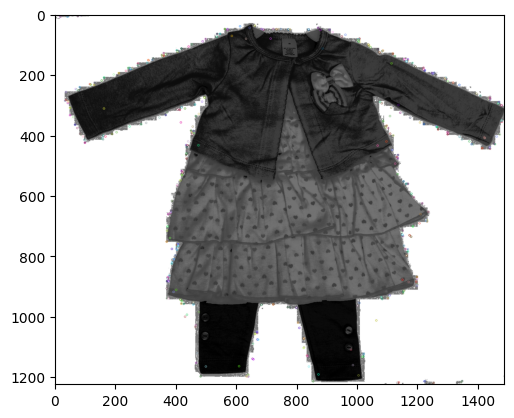

Descripteurs :  (500, 128)

[[  0.   0.   0. ...   0.   0.   1.]
 [105.  14.   0. ...   0.   0.   0.]
 [124.  55.   2. ...  10.   0.   1.]
 ...
 [  2.   2.   4. ...   0.   0.   2.]
 [ 14.   5.   0. ...   0.   0.   4.]
 [  5.  18.  22. ...   0.   0.   2.]]


In [ ]:
import cv2
n_kp = 500
sift = cv2.xfeatures2d.SIFT_create(n_kp)
image = cv2.imread(path+list_photos[8],0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)


## <a name="C22"> 2.2 Analyse via SIFT <a>

### Créations des descripteurs de chaque image
* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [ ]:
df_sample = df.sample(300)

In [ ]:
# identification of key points and associated descriptors
import time, cv2
sift_keypoints = []
temps1=time.time()
sift = cv2.xfeatures2d.SIFT_create()


for image_num in range(len(df_sample)) :
    if image_num%100 == 0 : print(image_num)
    filename = df_sample['image'].iloc[image_num]
    image = cv2.imread(path+filename,0) # convert in gray
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200

Nombre de descripteurs :  (2283542, 128)
temps de traitement SIFT descriptor :           299.25 secondes


### Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [ ]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

#k = int(round(np.sqrt(len(sift_keypoints_all)),0))
k = 80 #120 #60, 70
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  80
Création de 80 clusters de descripteurs ...
temps de traitement kmeans :             8.97 secondes


### Création des features des images
* Pour chaque image :
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [ ]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0
100
200
temps de création histogrammes :             9.23 secondes


### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [ ]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (300, 80)
Dimensions dataset après réduction PCA :  (300, 51)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [ ]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=25,
                     n_iter=3000, init='random', random_state=42)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["category"] = df_sample['category'].values
print(df_tsne.shape)


(300, 3)


In [ ]:
df_sample

In [ ]:
df_tsne

In [ ]:
'568f331e1039bf2e0635b899c2b3248f.jpg' in list_photos

In [ ]:
df_tsne['image'] = df_sample['image'].values

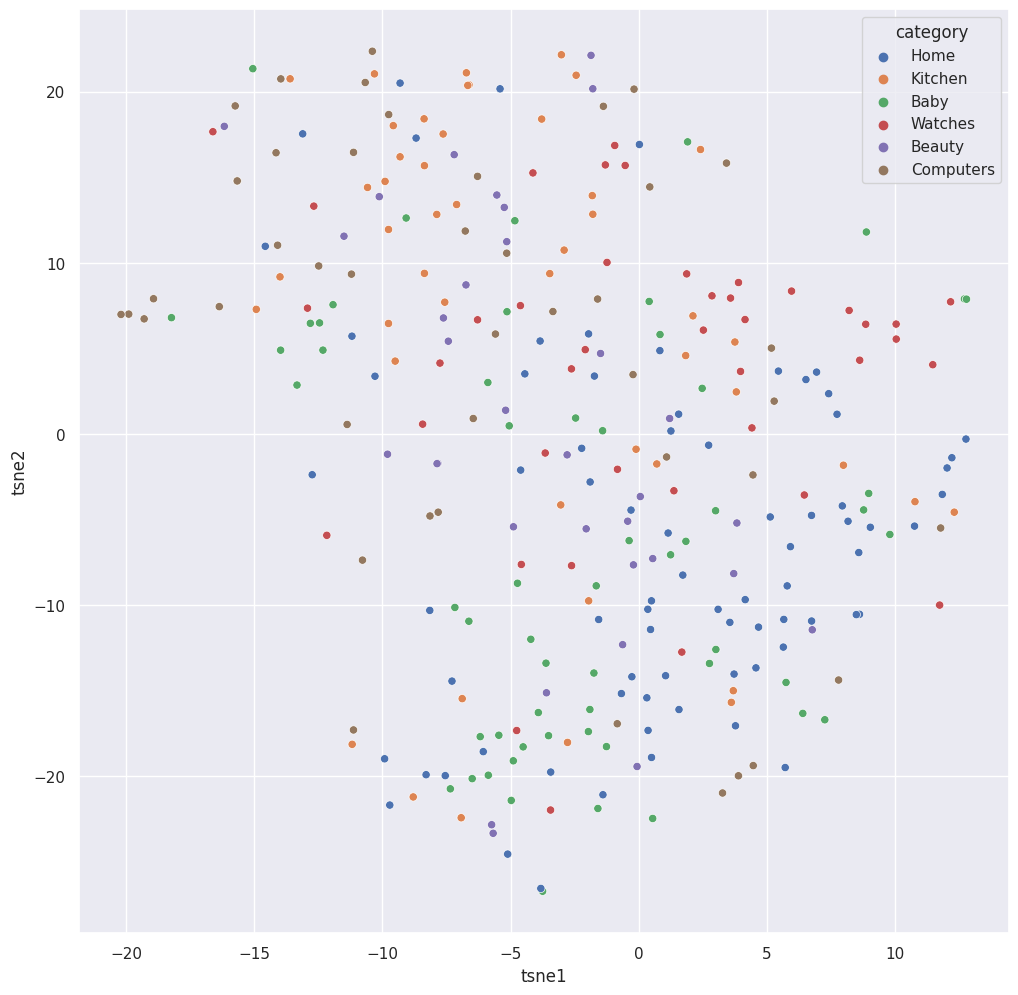

In [ ]:
sns.set()
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(data=df_tsne, x='tsne1', y='tsne2',hue = 'category')
  # randomly sample
tmp = df_tsne.sample(35)
  #add label to some random points per group
#for _,row in tmp.iterrows():
 # plt.annotate(row['product'], (row['Dim1'], row['Dim2']), size=7, color='k')
plt.savefig('/content/Fichier_N1/P6_N1_TSNE_SIFT.png')
plt.show()


###  Création de clusters à partir du T-SNE

In [ ]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=6, random_state=42)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)


(300, 5)


In [ ]:
df_tsne

###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters
* Le score ARI varie entre 0.05 et 0.09.

La technique SIFT n'est pas convaincante pour une étude préliminaire de faisabilité.

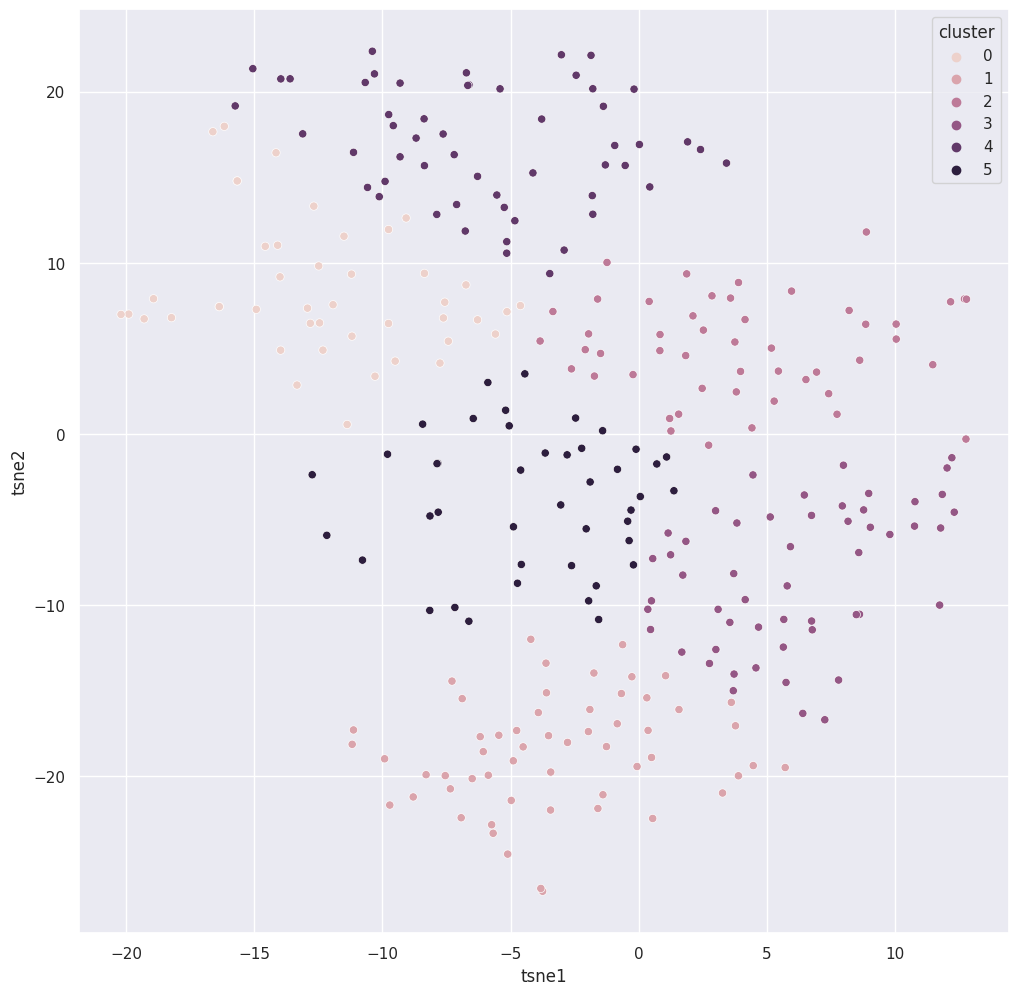

In [ ]:
sns.set()
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(data = df_tsne, x = 'tsne1', y= 'tsne2', hue ='cluster')

plt.savefig('/content/Fichier_N1/P6_N1_TSNE_k_means_SIFT.png')
plt.show()

## <a name="C23"> 2.3 Analyse via Transfer Learning <a>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

In [ ]:
base_model = VGG16() #on instancie le modèle de base sans paramètre particulier
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output) #On crée un modèle avec en input les inputs du modèle de base
#et en output la sortie de la couche -2 ,

print(model.summary())

- ### Création des features des images

In [ ]:
df.head()

In [ ]:
images_features = []
i=0
for image_file in df["image"]: #.loc[ind_sample] : #Échantillon de 300 images
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(path+image_file, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0
100
200
300
400
500
600
700
800
900
1000


(1050, 4096)

### Réduction de dimension

In [ ]:
from sklearn import manifold, decomposition

print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

(1050, 4096)
(1050, 803)


### Réduction de dimension T-SNE et affichage des images selon vraies classes

In [ ]:
from sklearn import manifold, decomposition
import time

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

temps de T-SNE :            25.48 secondes


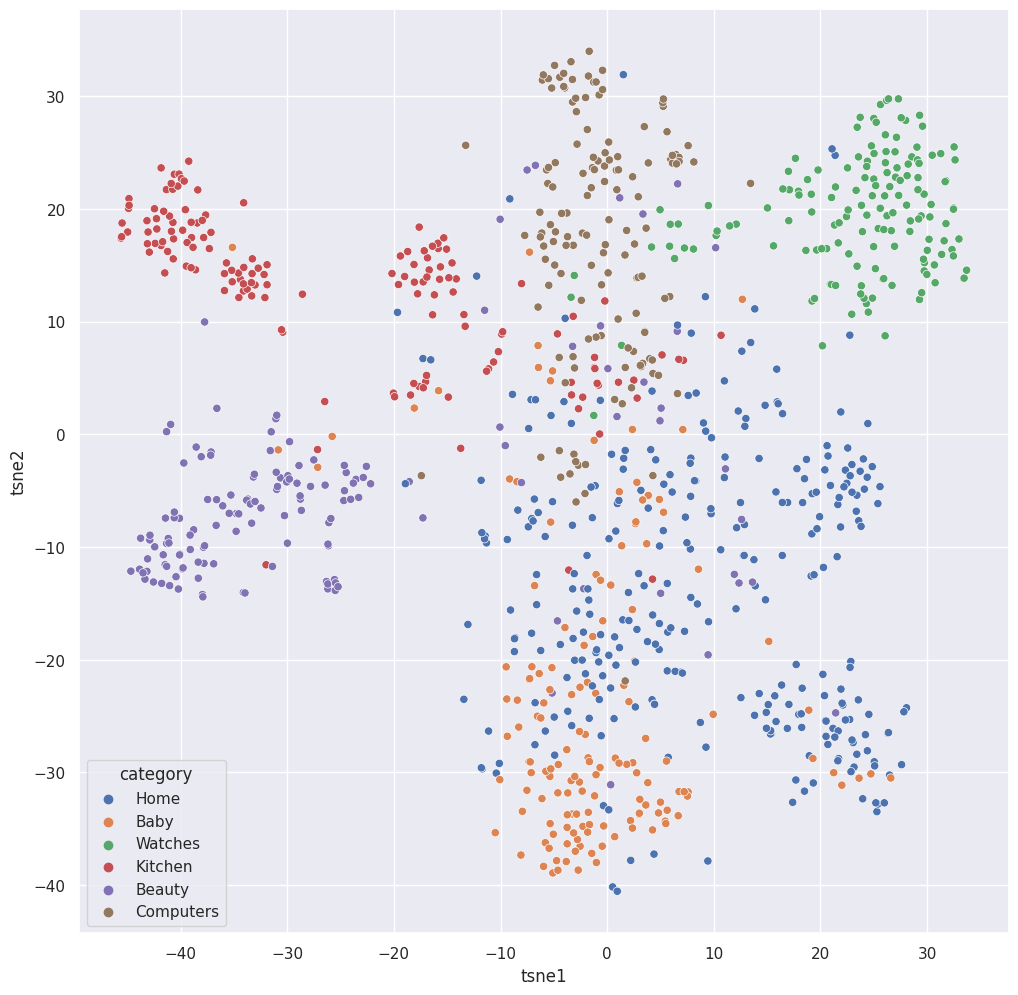

In [ ]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["category"] = df["category"] #.loc[ind_sample].values

sns.set()
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(data=df_tsne, x='tsne1', y='tsne2',hue = 'category')
  # randomly sample
tmp = df_tsne.sample(35)
  #add label to some random points per group
#for _,row in tmp.iterrows():
 # plt.annotate(row['product'], (row['Dim1'], row['Dim2']), size=7, color='k')
plt.savefig('/content/Fichier_N1/P6_N1_TSNE_VGG16.png')
plt.show()


In [ ]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=6, n_init=100)
cls.fit(X_tsne)

KMeans(n_clusters=6, n_init=100)

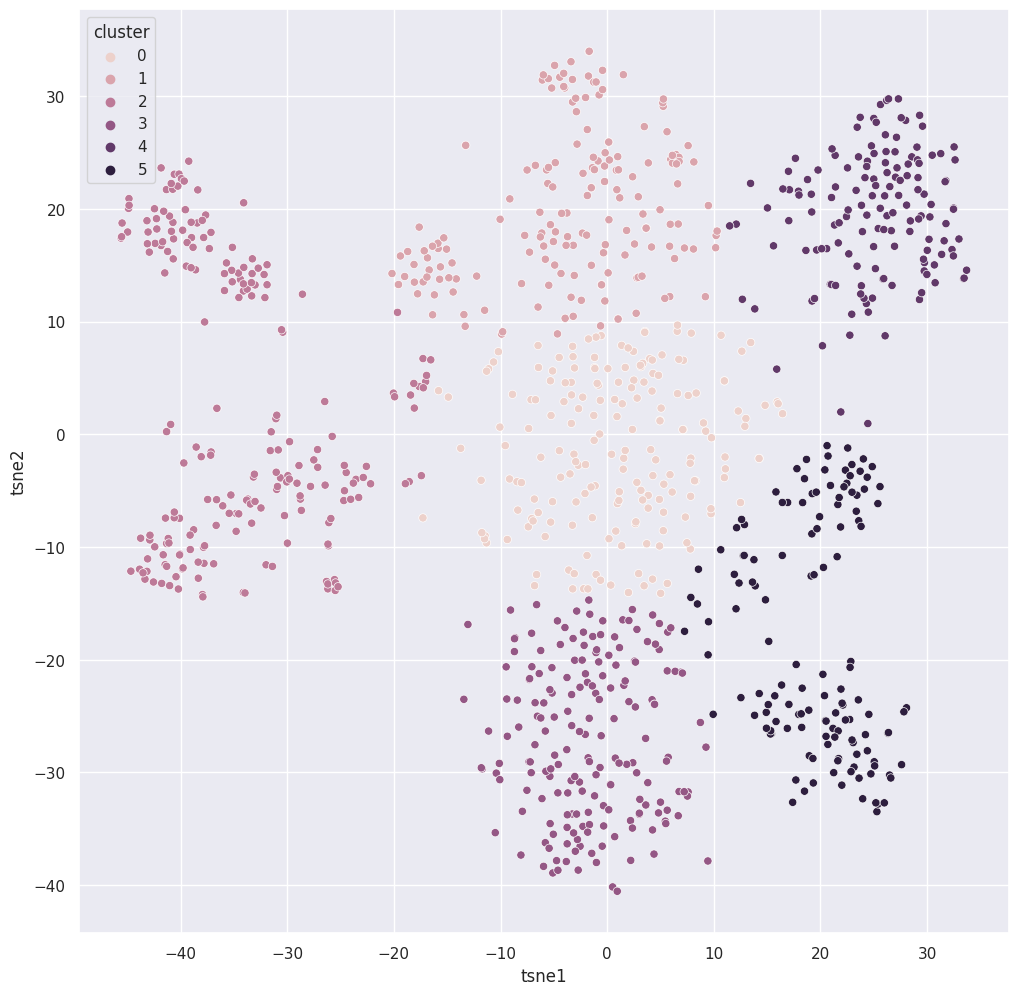

ARI :  0.3826038763563698


In [ ]:
df_tsne["cluster"] = cls.labels_

sns.set()
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(data = df_tsne, x = 'tsne1', y= 'tsne2', hue ='cluster')

plt.savefig('/content/Fichier_N1/P6_N1_TSNE_k_means_VGG16.png')
plt.show()
labels = df["category"]#.loc[ind_sample].values
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

In [ ]:
df_tsne

,tsne1,tsne2,category,cluster
0,17.968288,-24.849491,Home,5
1,2.572353,-20.118193,Baby,3
2,-2.545528,-22.436279,Baby,3
3,19.331619,-30.928423,Home,5
4,26.330675,-26.520670,Home,5
...,...,...,...,...
1045,18.910389,-24.468199,Baby,5
1046,4.898888,-5.773716,Baby,0
1047,15.154319,-18.366137,Baby,5
1048,5.288424,-6.912203,Baby,0
